# CLIP with conformal prediction

Comparing prediciton set size across different datasets

In [1]:
# import os; os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from pathlib import Path
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('bmh')
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, BatchSampler
assert torch.cuda.is_available()
import clip
import open_clip
from tqdm import tqdm
import wilds
from conformal import (
    get_quantile, make_prediction_sets, get_coverage, get_size, get_coverage_by_class
)
from dataset import ClipDataset, BalancedBatchSampler

2023-04-06 09:49:47.632398: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 09:49:47.770904: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-06 09:49:49.152836: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-06 09:49:49.152920: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

### CIFAR100

In [2]:
data_dir = Path('../data')
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
k = 10000
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

    
_transforms = transforms.Compose([
    transforms.ToPILImage(),
    preprocess,
])

cifar_train = datasets.CIFAR100(root=data_dir, train=True)
cifar_test = datasets.CIFAR100(root=data_dir, train=False)

cifar_classes = tuple(cifar_test.classes)
cifar_class_map = dict(map(reversed, cifar_test.class_to_idx.items()))
cifar_num_classes = len(cifar_classes)

cifar_train_ds = ClipDataset(cifar_train.data, cifar_train.targets, class_map=cifar_class_map, transforms=_transforms, k=k)
cifar_test_ds = ClipDataset(cifar_test.data, cifar_test.targets, class_map=cifar_class_map, transforms=_transforms, k=k)


In [4]:
from nltk.corpus import wordnet

In [5]:
cifar_definitions = {}
for _class in cifar_classes:
    orig_class = _class
    if _class == 'aquarium_fish':
        _class = 'aquarium'
    elif _class == 'maple_tree':
        _class = 'maple'
    syns = wordnet.synsets(_class)
    if len(syns) == 0:
        print(_class.center(40, '-'))
        continue
    definition = syns[0].definition()
    # print(syns[0].name(), len(syns))
    cifar_definitions[orig_class] = definition

In [6]:
superclasses = {
    'beaver': 'aquatic_mammal', 
    'dolphin': 'aquatic_mammal', 
    'otter': 'aquatic_mammal', 
    'seal': 'aquatic_mammal', 
    'whale': 'aquatic_mammal',
    
    'aquarium_fish': 'fish', 
    'flatfish': 'fish', 
    'ray':      'fish', 
    'shark':    'fish', 
    'trout':    'fish', 

    'orchid': 'flower', 
    'poppy': 'flower', 
    'rose': 'flower', 
    'sunflower': 'flower', 
    'tulip':'flower', 
    
    'bottle': 'food_container', 
    'bowl': 'food_container', 
    'can': 'food_container', 
    'cup': 'food_container', 
    'plate': 'food_container',
    
    'apple': 'fruit_and_vegetable',
    'mushroom': 'fruit_and_vegetable',
    'orange': 'fruit_and_vegetable',
    'pear': 'fruit_and_vegetable',
    'sweet_pepper': 'fruit_and_vegetable',
    
    'clock': 'household_electrical_device', 
    'keyboard': 'household_electrical_device', 
    'lamp': 'household_electrical_device', 
    'telephone': 'household_electrical_device', 
    'television': 'household_electrical_device',
    
    'bed': 'household_furniture' , 
    'chair': 'household_furniture' , 
    'couch': 'household_furniture' , 
    'table': 'household_furniture' , 
    'wardrobe':'household_furniture',
    
    'bee': 'insect', 
    'beetle': 'insect', 
    'butterfly': 'insect', 
    'caterpillar': 'insect', 
    'cockroach': 'insect',
    
    'bear': 'large_carnivore', 
    'leopard': 'large_carnivore', 
    'lion': 'large_carnivore', 
    'tiger': 'large_carnivore', 
    'wolf': 'large_carnivore',
    
    'bridge': 'large_man-made_outdoor_thing', 
    'castle': 'large_man-made_outdoor_thing', 
    'house': 'large_man-made_outdoor_thing', 
    'road': 'large_man-made_outdoor_thing', 
    'skyscraper': 'large_man-made_outdoor_thing',

    'cloud': 'large_natural_outdoor_scene' , 
    'forest': 'large_natural_outdoor_scene' , 
    'mountain': 'large_natural_outdoor_scene' , 
    'plain': 'large_natural_outdoor_scene' , 
    'sea': 'large_natural_outdoor_scene' ,
    
    'camel': 'large_omnivores_and_herbivore', 
    'cattle': 'large_omnivores_and_herbivore', 
    'chimpanzee': 'large_omnivores_and_herbivore', 
    'elephant': 'large_omnivores_and_herbivore', 
    'kangaroo': 'large_omnivores_and_herbivore',

    'fox': 'medium-sized_mammal', 
    'porcupine': 'medium-sized_mammal', 
    'possum': 'medium-sized_mammal', 
    'raccoon': 'medium-sized_mammal', 
    'skunk': 'medium-sized_mammal',

    'crab': 'non-insect_invertebrate', 
    'lobster': 'non-insect_invertebrate', 
    'snail': 'non-insect_invertebrate', 
    'spider': 'non-insect_invertebrate', 
    'worm': 'non-insect_invertebrate',
    
    'baby': 'people', 
    'boy': 'people', 
    'girl': 'people', 
    'man': 'people', 
    'woman': 'people',

    'crocodile': 'reptile', 
    'dinosaur': 'reptile', 
    'lizard': 'reptile', 
    'snake': 'reptile', 
    'turtle': 'reptile',
    
    'hamster': 'small_mammal', 
    'mouse': 'small_mammal', 
    'rabbit': 'small_mammal', 
    'shrew': 'small_mammal', 
    'squirrel': 'small_mammal',
    
    'maple_tree': 'tree', 
    'oak_tree': 'tree', 
    'palm_tree': 'tree', 
    'pine_tree': 'tree', 
    'willow_tree': 'tree',

    'bicycle': 'vehicle', 
    'bus': 'vehicle', 
    'motorcycle': 'vehicle', 
    'pickup_truck': 'vehicle', 
    'train': 'vehicle', 
    'lawn_mower':  'vehicle', 
    'rocket': 'vehicle', 
    'streetcar': 'vehicle', 
    'tank': 'vehicle', 
    'tractor': 'vehicle', 
}



In [7]:
for _class in sorted(cifar_definitions.keys()):
    assert superclasses[_class], _class

In [8]:
def get_features(model, dataset, device):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, text in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [9]:
cifar_train_features, cifar_train_labels = get_features(model, cifar_train_ds, device)
cifar_test_features, cifar_test_labels = get_features(model, cifar_test_ds, device)

100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


In [32]:
classes_2

[' beaver aquatic mammal',
 ' dolphin aquatic mammal',
 ' otter aquatic mammal',
 ' seal aquatic mammal',
 ' whale aquatic mammal',
 ' aquarium fish fish',
 ' flatfish fish',
 ' ray fish',
 ' shark fish',
 ' trout fish',
 ' orchid flower',
 ' poppy flower',
 ' rose flower',
 ' sunflower flower',
 ' tulip flower',
 ' bottle food container',
 ' bowl food container',
 ' can food container',
 ' cup food container',
 ' plate food container',
 ' apple fruit and vegetable',
 ' mushroom fruit and vegetable',
 ' orange fruit and vegetable',
 ' pear fruit and vegetable',
 ' sweet pepper fruit and vegetable',
 ' clock household electrical device',
 ' keyboard household electrical device',
 ' lamp household electrical device',
 ' telephone household electrical device',
 ' television household electrical device',
 ' bed household furniture',
 ' chair household furniture',
 ' couch household furniture',
 ' table household furniture',
 ' wardrobe household furniture',
 ' bee insect',
 ' beetle insect

In [42]:
template = 'this is an image of a '
classes_1 = [f'{template} {k}'.replace('_', ' ') for k in cifar_classes]
classes_2 = [f'{template} {k} a type of {superclasses[k]}'.replace('_', ' ') for k in cifar_classes]
classes_3 = [f'{template} {k} definition {cifar_definitions[k]}' for k in cifar_classes]

In [43]:
all_targets = []
all_scores_1 = []
all_scores_2 = []
all_scores_3 = []

with torch.no_grad(), torch.cuda.amp.autocast():

    text_1_features = model.encode_text(clip.tokenize(classes_1).cuda())
    text_2_features = model.encode_text(clip.tokenize(classes_2).cuda())
    text_3_features = model.encode_text(clip.tokenize(classes_3).cuda())
    
    text_1_features /= text_1_features.norm(dim=-1, keepdim=True)
    text_2_features /= text_2_features.norm(dim=-1, keepdim=True)
    text_3_features /= text_3_features.norm(dim=-1, keepdim=True)
    
    for i in tqdm(range(len(cifar_test))):
        x, y = cifar_train[i]

        image_features = model.encode_image(preprocess(x).unsqueeze(0).cuda())

        scores_1 = (image_features @ text_1_features.T).softmax(-1)
        scores_2 = (image_features @ text_2_features.T).softmax(-1)
        scores_3 = (image_features @ text_3_features.T).softmax(-1)

        all_targets.append(y)
        all_scores_1.append(scores_1.detach().cpu())
        all_scores_2.append(scores_2.detach().cpu())
        all_scores_3.append(scores_3.detach().cpu())


100%|██████████| 10000/10000 [01:46<00:00, 94.02it/s]


In [51]:
targets = torch.tensor(all_targets)
scores_1 = torch.cat(all_scores_1)
scores_2 = torch.cat(all_scores_2)
scores_3 = torch.cat(all_scores_3)
print((targets == scores_1.argmax(1)).sum() / len(scores_1))
print((targets == scores_2.argmax(1)).sum() / len(scores_2))
print((targets == scores_3.argmax(1)).sum() / len(scores_3))

tensor(0.6320)
tensor(0.6245)
tensor(0.5528)


In [44]:
def conformal_prediction(scores, targets, cal_frac=0.1, alpha=0.1):
    n = scores.shape[0]
    acc = (scores.argmax(1) == targets).sum() / n
    
    print(f'ACCURACY: {acc:.1%}')

    n = int(round(cal_frac * n))
    cal_scores = torch.tensor(scores[:n], dtype=torch.float)
    cal_targets = torch.tensor(targets[:n], dtype=torch.long)
    val_scores = torch.tensor(scores[n:], dtype=torch.float)
    val_targets = torch.tensor(targets[n:], dtype=torch.long)

    qhat = get_quantile(cal_scores, cal_targets, alpha=alpha)
    psets = make_prediction_sets(val_scores, qhat)

    print(f'COVERAGE: {get_coverage(psets, val_targets):.1%}')
    print(f'SET SIZE: {get_size(psets):.1f}')
    return psets, val_targets

In [53]:
psets_1, _ = conformal_prediction(scores_1.cpu(), targets.cpu())
psets_2, _ = conformal_prediction(scores_2.cpu(), targets.cpu())
psets_3, _ = conformal_prediction(scores_3.cpu(), targets.cpu())

ACCURACY: 63.2%
COVERAGE: 89.6%
SET SIZE: 7.6
ACCURACY: 62.4%


/state/partition1/slurm_tmp/22309852.0.0/ipykernel_34497/2928160459.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cal_scores = torch.tensor(scores[:n], dtype=torch.float)
/state/partition1/slurm_tmp/22309852.0.0/ipykernel_34497/2928160459.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cal_targets = torch.tensor(targets[:n], dtype=torch.long)
/state/partition1/slurm_tmp/22309852.0.0/ipykernel_34497/2928160459.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_scores = torch.tensor(scores[n:], dtype=torch.float)
/state/part

COVERAGE: 88.5%
SET SIZE: 7.3
ACCURACY: 55.3%
COVERAGE: 90.3%
SET SIZE: 12.7


In [54]:
psets_1.sum(1)

tensor([6, 7, 3,  ..., 8, 9, 5])

([<matplotlib.axis.YTick at 0x7fdbc41ef880>,
 [Text(0, 1, 'original'), Text(0, 2, 'superclass'), Text(0, 3, 'definition')])

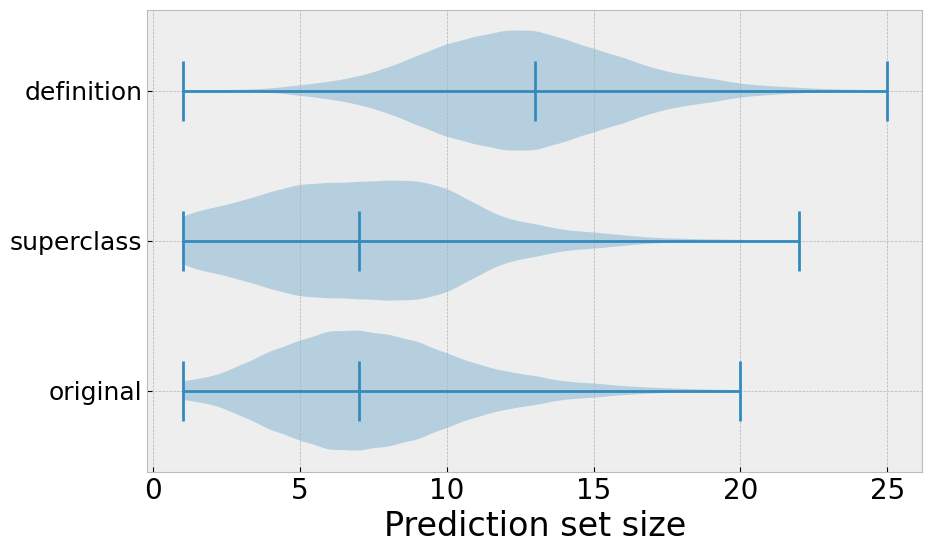

In [59]:
sizes = [
    psets_1.sum(1),
    psets_2.sum(1),
    psets_3.sum(1),
]

fontsize=24
plt.figure(figsize=(10, 6))
plt.violinplot(sizes, vert=False, widths=0.8, showmedians=True)
plt.xlabel('Prediction set size', fontsize=fontsize)
plt.xticks(fontsize=fontsize-4)
plt.yticks(ticks=range(1, 4), labels=[f'original', f'superclass', f'definition'], fontsize=fontsize-6)

tensor([19, 63,  0,  ...,  3, 26, 23])

In [ ]:

with torch.no_grad(), torch.cuda.amp.autocast():
    prompt = tokenizer(['This is an image of a ' + c for c in imagenet_classes])
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for i in tqdm(range(len(imagenet_test_dataset))):
        x, y = imagenet_test_dataset[i]
        image_features = model.encode_image(preprocess(x).unsqueeze(0))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        scores = (image_features @ text_features.T).softmax(dim=-1)
        
        imagenet_true_class.append(y)
        imagenet_pred_class.append(scores.argmax().item())
        imagenet_pred_scores.append(scores.detach().cpu().numpy().squeeze())
        
imagenet_true_class = np.asarray(imagenet_true_class)
imagenet_pred_class = np.asarray(imagenet_pred_class)
imagenet_pred_scores = np.asarray(imagenet_pred_scores)

imagenet_acc = (imagenet_true_class == imagenet_pred_class).sum() / imagenet_true_class.shape[0]
print(f'imagenet100 accuracy: {imagenet_acc:.1%}')

In [ ]:
    prompt = tokenizer(['This is an image of a ' + c for c in imagenet_classes])
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)


In [ ]:
cifar_psets_no_finetune, cifar_targets_no_finetune = conformal_prediction(model, cifar_test_ds, classes=cifar_classes)


In [11]:
from sklearn.linear_model import LogisticRegression

# Perform logistic regression
cifar_classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
cifar_classifier.fit(cifar_train_features, cifar_train_labels)

# Evaluate using the logistic regression classifier
cifar_predictions = classifier.predict(cifar_test_features)
cifar_accuracy = np.mean((cifar_test_labels == cifar_predictions).astype(float)) * 100.
print(f"Accuracy = {cifar_accuracy:.3f}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60517D+04    |proj g|=  3.11398D+02

At iterate   50    f=  7.24204D+03    |proj g|=  4.56411D+01

At iterate  100    f=  6.77026D+03    |proj g|=  1.40644D+01

At iterate  150    f=  6.75127D+03    |proj g|=  6.48170D+00

At iterate  200    f=  6.74988D+03    |proj g|=  4.57239D+00

At iterate  250    f=  6.74330D+03    |proj g|=  1.24446D+01

At iterate  300    f=  6.73569D+03    |proj g|=  9.74934D+00

At iterate  350    f=  6.73517D+03    |proj g|=  1.60923D+00

At iterate  400    f=  6.73514D+03    |proj g|=  4.91326D-01

At iterate  450    f=  6.73503D+03    |proj g|=  5.55141D-01

At iterate  500    f=  6.73482D+03    |proj g|=  4.48665D-01

At iterate  550    f=  6.73479D+03    |proj g|=  5.11346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


In [25]:
cifar_test_scores = classifier.predict_proba(cifar_test_features)
cifar_psets_no_finetune, cifar_targets_no_finetune = conformal_prediction(cifar_test_scores, cifar_test_labels)

In [2]:
def finetune(model, train_dl, test_dl=None, epochs=1, batch_size=100, save_name=None):

    #https://github.com/openai/CLIP/issues/57
    def convert_models_to_fp32(model): 
        for p in model.parameters(): 
            if p.requires_grad:
                p.data = p.data.float() 
                p.grad.data = p.grad.data.float() 

    if device == "cpu":
        model.float()
        
    for name, param in model.named_parameters():
        if name not in [
            'transformer.resblocks.11.mlp.c_fc.weight',
            'transformer.resblocks.11.mlp.c_fc.bias',
            'transformer.resblocks.11.mlp.c_proj.weight',
            'transformer.resblocks.11.mlp.c_proj.bias',
            'transformer.resblocks.11.ln_2.weight',
            'transformer.resblocks.11.ln_2.bias',
            'token_embedding.weight',
            'ln_final.weight',
            'ln_final.bias',
        ]:
            param.requires_grad = False

    loss_img = nn.CrossEntropyLoss()
    loss_txt = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
    model.visual.transformer.resblocks[-1].mlp.requires_grad_()
    params_to_update = model.visual.transformer.resblocks[-1].mlp
    optimizer = optim.Adam(params_to_update.parameters(), lr=1e-5)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dl)*epochs)

    best_te_loss = 1e5
    best_ep = -1
    for epoch in range(epochs):
        print(f"running epoch {epoch}, best test loss {best_te_loss} after epoch {best_ep}")
        step = 0
        tr_loss = 0
        model.train()
        pbar = tqdm(train_dl, leave=False)
        for batch in pbar:
            step += 1
            optimizer.zero_grad()

            images, labels, texts = batch
            images = images.to(device)
            texts = clip.tokenize(texts).to(device)
    #         print(images.shape, texts.shape)
            logits_per_image, logits_per_text = model(images, texts)
            ground_truth = torch.arange(batch_size).to(device)

            total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth))/2
            total_loss.backward()
            tr_loss += total_loss.item()
            if device == "cpu":
                optimizer.step()
                # scheduler.step()
            else:
                convert_models_to_fp32(model)
                optimizer.step()
                # scheduler.step()
                clip.model.convert_weights(model)
            pbar.set_description(f"train batch CE: {total_loss.item()}", refresh=True)
        tr_loss /= step

    if test_dl is not None:
        step = 0
        te_loss = 0
        with torch.no_grad():
            model.eval()
            test_pbar = tqdm(test_dl, leave=False)
            for batch in test_pbar:
                step += 1
                images, labels, texts = batch
                images = images.to(device)
                texts = clip.tokenize(texts).to(device)
                logits_per_image, logits_per_text = model(images, texts)
                ground_truth = torch.arange(batch_size).to(device)

                total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth))/2
                te_loss += total_loss.item()
                test_pbar.set_description(f"test batch CE: {total_loss.item()}", refresh=True)
            te_loss /= step

        if te_loss < best_te_loss:
            best_te_loss = te_loss
            best_ep = epoch
            if save_name is not None:
                torch.save(model.state_dict(), f"model_{save_name}_best.pt")
        print(f"epoch {epoch}, tr_loss {tr_loss}, te_loss {te_loss}")

        if save_name is not None:
            torch.save(model.state_dict(), f"model_{save_name}_last.pt")
    return model

In [16]:
def evaluate(model, test_ds, classes):
    true_class = []
    pred_class = []
    pred_scores = []

    with torch.no_grad(), torch.cuda.amp.autocast():
        prompt = clip.tokenize(['a ' + c for c in classes]).cuda()
        text_features = model.encode_text(prompt)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        for i in tqdm(range(len(test_ds))):
            x, y, _ = test_ds[i]
            image_features = model.encode_image(x.unsqueeze(0).cuda())
            image_features /= image_features.norm(dim=-1, keepdim=True)
            scores = (image_features @ text_features.T).softmax(dim=-1)

            true_class.append(y)
            pred_class.append(scores.argmax().item())
            pred_scores.append(scores.detach().cpu().numpy().squeeze())

    true_class = np.asarray(true_class)
    pred_class = np.asarray(pred_class)
    pred_scores = np.asarray(pred_scores)

    return true_class, pred_class, pred_scores

In [24]:
def conformal_prediction(scores, targets, cal_frac=0.1, alpha=0.1):
    n = scores.shape[0]
    acc = (scores.argmax(1) == targets).sum() / n
    
    print(f'ACCURACY: {acc:.1%}')

    n = int(round(cal_frac * n))
    cal_scores = torch.tensor(scores[:n], dtype=torch.float)
    cal_targets = torch.tensor(targets[:n], dtype=torch.long)
    val_scores = torch.tensor(scores[n:], dtype=torch.float)
    val_targets = torch.tensor(targets[n:], dtype=torch.long)

    qhat = get_quantile(cal_scores, cal_targets, alpha=alpha)
    psets = make_prediction_sets(val_scores, qhat)

    print(f'COVERAGE: {get_coverage(psets, val_targets):.1%}')
    print(f'SET SIZE: {get_size(psets):.1f}')
    return psets, val_targets

In [18]:
def get_features(model, dataset, device):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, text in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

### CIFAR100

In [2]:
data_dir = Path('../data')
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
k = 10000
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

    
_transforms = transforms.Compose([
    transforms.ToPILImage(),
    preprocess,
])

cifar_train = datasets.CIFAR100(root=data_dir, train=True)
cifar_test = datasets.CIFAR100(root=data_dir, train=False)

cifar_classes = tuple(cifar_test.classes)
cifar_class_map = dict(map(reversed, cifar_test.class_to_idx.items()))
cifar_num_classes = len(cifar_classes)

cifar_train_ds = ClipDataset(cifar_train.data, cifar_train.targets, class_map=cifar_class_map, transforms=_transforms, k=k)
cifar_test_ds = ClipDataset(cifar_test.data, cifar_test.targets, class_map=cifar_class_map, transforms=_transforms, k=k)


In [42]:
cifar_train_features, cifar_train_labels = get_features(model, cifar_train_ds, device)
cifar_test_features, cifar_test_labels = get_features(model, cifar_test_ds, device)

100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


In [11]:
from sklearn.linear_model import LogisticRegression

# Perform logistic regression
cifar_classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
cifar_classifier.fit(cifar_train_features, cifar_train_labels)

# Evaluate using the logistic regression classifier
cifar_predictions = classifier.predict(cifar_test_features)
cifar_accuracy = np.mean((cifar_test_labels == cifar_predictions).astype(float)) * 100.
print(f"Accuracy = {cifar_accuracy:.3f}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60517D+04    |proj g|=  3.11398D+02

At iterate   50    f=  7.24204D+03    |proj g|=  4.56411D+01

At iterate  100    f=  6.77026D+03    |proj g|=  1.40644D+01

At iterate  150    f=  6.75127D+03    |proj g|=  6.48170D+00

At iterate  200    f=  6.74988D+03    |proj g|=  4.57239D+00

At iterate  250    f=  6.74330D+03    |proj g|=  1.24446D+01

At iterate  300    f=  6.73569D+03    |proj g|=  9.74934D+00

At iterate  350    f=  6.73517D+03    |proj g|=  1.60923D+00

At iterate  400    f=  6.73514D+03    |proj g|=  4.91326D-01

At iterate  450    f=  6.73503D+03    |proj g|=  5.55141D-01

At iterate  500    f=  6.73482D+03    |proj g|=  4.48665D-01

At iterate  550    f=  6.73479D+03    |proj g|=  5.11346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


In [25]:
cifar_test_scores = classifier.predict_proba(cifar_test_features)
cifar_psets_no_finetune, cifar_targets_no_finetune = conformal_prediction(cifar_test_scores, cifar_test_labels)

In [92]:
sample = next(iter(cifar_train_dl))[2]
batch_size = len(sample)
assert batch_size == len(set(sample))

In [93]:
cifar_psets_no_finetune, cifar_targets_no_finetune = conformal_prediction(model, cifar_test_ds, classes=cifar_classes)

100%|██████████| 10000/10000 [01:33<00:00, 106.90it/s]

ACCURACY: 60.2%
COVERAGE: 90.2%
SET SIZE: 9.2


In [94]:
model = finetune(model, cifar_train_dl, test_dl=None, epochs=1, batch_size=cifar_num_classes, save_name=None)

running epoch 0, best test loss 100000.0 after epoch -1


In [95]:
cifar_psets_finetune, cifar_targets_finetune = conformal_prediction(model, cifar_test_ds, classes=cifar_classes)

100%|██████████| 10000/10000 [01:34<00:00, 106.31it/s]

ACCURACY: 64.5%
COVERAGE: 90.7%
SET SIZE: 6.8


### ImageNet

In [33]:
k = 40000
val_data = np.load(data_dir/'Imagenet64_val_npz/val_data.npz')
images = val_data['data'].reshape(-1, 3, 64, 64)
labels = val_data['labels']
random_perm = np.random.permutation(images.shape[0])
train_subset = random_perm[:k]
test_subset = random_perm[k:]
train_images = images[train_subset]
train_labels = labels[train_subset]
test_images = images[test_subset]
test_labels = labels[test_subset]
df = pd.read_csv(data_dir/'map_clsloc.txt', sep=' ', header=None, names=['id', 'index', 'class'])
df['index'] = df['index'] - 1
imagenet_classes = df['class'].values
imagenet_num_classes = len(imagenet_classes)
imagenet_class_map = dict(df[['index', 'class']].values)

imagenet_train_ds = ClipDataset(
    train_images, train_labels, 
    transforms=transforms.Compose([
        transforms.Lambda(lambda x: np.moveaxis(x, 0, -1)),
        transforms.ToPILImage(),
        preprocess,
    ]),
    target_transforms=transforms.Lambda(lambda y: y - 1),
    class_map=imagenet_class_map,
    k=k,
)
imagenet_test_ds = ClipDataset(
    test_images, test_labels, 
    transforms=transforms.Compose([
        transforms.Lambda(lambda x: np.moveaxis(x, 0, -1)),
        transforms.ToPILImage(),
        preprocess,
    ]),
    target_transforms=transforms.Lambda(lambda y: y - 1),
    class_map=imagenet_class_map,
    k=len(test_labels),
)
# imagenet_train_sampler = BalancedBatchSampler(train_labels, imagenet_num_classes)
# imagenet_train_dl = DataLoader(imagenet_train_ds, batch_sampler=imagenet_train_sampler)
# imagenet_test_sampler = BalancedBatchSampler(test_labels, imagenet_num_classes)
# imagenet_test_dl = DataLoader(imagenet_test_ds, batch_sampler=imagenet_test_sampler)

In [34]:
imagenet_train_features, imagenet_train_labels = get_features(model, imagenet_train_ds, device)
imagenet_test_features, imagenet_test_labels = get_features(model, imagenet_test_ds, device)

100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


In [38]:
imagenet_test_features.shape

(10000, 512)

In [35]:
from sklearn.linear_model import LogisticRegression

# Perform logistic regression
imagenet_classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
imagenet_classifier.fit(imagenet_train_features, imagenet_train_labels)

# Evaluate using the logistic regression classifier
imagenet_predictions = classifier.predict(imagenet_test_features)
imagenet_accuracy = np.mean((imagenet_test_labels == imagenet_predictions).astype(float)) * 100.
print(f"Accuracy = {imagenet_accuracy:.3f}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       513000     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76310D+05    |proj g|=  1.13046D+02


 This problem is unconstrained.



At iterate   50    f=  5.06982D+04    |proj g|=  8.86100D+01

At iterate  100    f=  4.98410D+04    |proj g|=  1.11898D+01

At iterate  150    f=  4.98080D+04    |proj g|=  8.53436D+00

At iterate  200    f=  4.97108D+04    |proj g|=  9.36337D+00

At iterate  250    f=  4.97077D+04    |proj g|=  1.05749D+00

At iterate  300    f=  4.97054D+04    |proj g|=  2.64765D+00

At iterate  350    f=  4.97042D+04    |proj g|=  7.56952D-01

At iterate  400    f=  4.97041D+04    |proj g|=  4.53872D-01

At iterate  450    f=  4.97040D+04    |proj g|=  1.27979D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    459    476   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.7min finished


In [40]:
imagenet_test_scores = imagenet_classifier.predict_proba(imagenet_test_features)
imagenet_psets_no_finetune, imagenet_targets_no_finetune = conformal_prediction(imagenet_test_scores, imagenet_test_labels)

ACCURACY: 87.1%
COVERAGE: 91.6%
SET SIZE: 1.3


In [86]:
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
_transforms = transforms.Compose([
    transforms.ToPILImage(),
    preprocess,
])
epochs = 1
sample = next(iter(imagenet_train_dl))[2]
batch_size = len(sample)
# assert batch_size == len(set(sample))

In [87]:
imagenet_psets_no_finetune, imagenet_targets_no_finetune = conformal_prediction(model, imagenet_test_ds, classes=imagenet_classes)

100%|██████████| 10000/10000 [01:35<00:00, 104.94it/s]

ACCURACY: 35.8%
COVERAGE: 89.8%
SET SIZE: 59.9


In [88]:
model = finetune(model, imagenet_train_dl, test_dl=None, epochs=epochs, batch_size=imagenet_num_classes, save_name=None)

running epoch 0, best test loss 100000.0 after epoch -1


In [89]:
imagenet_psets_finetune, imagenet_targets_finetune = conformal_prediction(model, imagenet_test_ds, classes=imagenet_classes)

100%|██████████| 10000/10000 [01:46<00:00, 94.30it/s]

ACCURACY: 43.0%
COVERAGE: 89.8%
SET SIZE: 41.2


([<matplotlib.axis.YTick at 0x7f49908485b0>,
 [Text(0, 1, 'CIFAR100 \n no probing'),
  Text(0, 2, 'CIFAR100 \n with probing'),
  Text(0, 3, 'Mini-ImageNet \n no probing'),
  Text(0, 4, 'Mini-ImageNet \n with probing')])

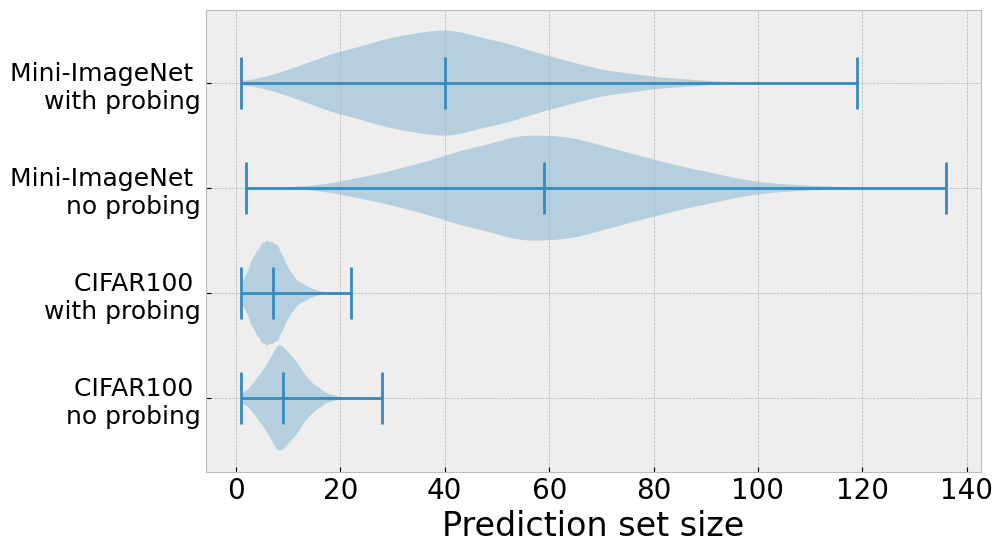

In [103]:
sizes = [
    cifar_psets_no_finetune.sum(1),
    cifar_psets_finetune.sum(1),
    imagenet_psets_no_finetune.sum(1),
    imagenet_psets_finetune.sum(1),
]
fontsize=24
plt.figure(figsize=(10, 6))
plt.violinplot(sizes, vert=False, widths=1.0, showmedians=True)
plt.xlabel('Prediction set size', fontsize=fontsize)
plt.xticks(fontsize=fontsize-4)
plt.yticks(ticks=range(1, 5), labels=[f'CIFAR100 \n no probing', f'CIFAR100 \n with probing', f'Mini-ImageNet \n no probing', f'Mini-ImageNet \n with probing'], fontsize=fontsize-6)

### iwildcam (TODO)

In [80]:
wild_dataset = wilds.get_dataset(dataset='iwildcam', root_dir=data_dir/'wilds')
wild_train = wild_dataset.get_subset('id_val')
wild_test = wild_dataset.get_subset('id_test', frac=1.0)
print(len(wild_train), len(wild_test))

wild_df = pd.read_csv(wild_dataset._data_dir / 'categories.csv')
wild_class_map = dict(wild_df[['y', 'name']].values)
wild_classes = tuple(wild_class_map.values())
wild_num_classes = len(wild_class_map)

wild_train_sampler = BalancedBatchSampler(train_labels, wild_num_classes)
wild_train_dl = DataLoader(wild_train_ds, batch_sampler=wild_train_sampler)
wild_test_sampler = BalancedBatchSampler(test_labels, wild_num_classes)
wild_test_dl = DataLoader(wild_test_ds, batch_sampler=wild_test_sampler)

7314 8154


NameError: name 'wild_train_ds' is not defined

In [83]:
wild_train.y_array

tensor([ 8,  8,  8,  ..., 52, 52, 52])

# OLD 

## datasets

In [3]:
# df = pd.read_csv(data_dir/'tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None)
# words_map = dict(pd.read_csv(data_dir/'tiny-imagenet-200/words.txt', sep='\t', header=None).values)
# all_words = sorted([x if isinstance(x, str) else '#' for x in words_map.values()])
# df.insert(1, 'target', df.iloc[:, 1].map(words_map))
# test_words = sorted(set(df.target.values))
# test_words_map = dict(map(reversed, enumerate(test_words)))
# df.insert(2, 'target_index', df.target.map(test_words_map))
# df.rename(columns={0: 'image'}, inplace=True)

In [4]:
k = 10000
val_data = np.load(data_dir/'Imagenet64_val_npz/val_data.npz')
images = val_data['data'].reshape(-1, 3, 64, 64)
labels = val_data['labels']
subset = np.random.permutation(images.shape[0])[:k]
images = images[subset]
labels = labels[subset]
df = pd.read_csv(data_dir/'map_clsloc.txt', sep=' ', header=None, names=['id', 'index', 'class'])

In [5]:
cifar_classes = tuple(cifar_test.classes)
cifar_class_map = dict(map(reversed, cifar_test.class_to_idx.items()))

In [6]:
class DS(Dataset):
    def __init__(self, images, labels, transforms=None, target_transforms=None):
        assert len(images) == len(labels)
        self.images = images
        self.labels = labels
        self.transforms = transforms
        self.target_transforms = target_transforms
        
    def __getitem__(self, k):
        x = self.images[k]
        y = self.labels[k]
        if self.transforms is not None:
            x = self.transforms(x)
        if self.target_transforms is not None:
            y = self.target_transforms(y)
        return x, y
    
    def __len__(self):
        return len(self.images)
    

In [7]:
imagenet_test_dataset = DS(
    images, labels, 
    transforms=transforms.Compose([
        transforms.Lambda(lambda x: np.moveaxis(x, 0, -1)),
        transforms.ToPILImage(),
    ]),
    target_transforms=transforms.Lambda(lambda y: y - 1),
)

In [8]:
cifar_test_dataset = DS(
    cifar_test.data, cifar_test.targets,
    transforms=transforms.Compose([
        # transforms.ToTensor(),
        # transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
        transforms.ToPILImage(),
    ]), 
)

loader_params = dict(batch_size=16, shuffle=False, pin_memory=True, num_workers=8)
cifar_test_loader = DataLoader(cifar_test_dataset, **loader_params)

In [11]:
len(wild_test_od), len(wild_test_id)

(8558, 8154)

## CLIP model

In [12]:
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')

In [13]:
imagenet_classes = df['class'].values

In [14]:
imagenet_true_class = []
imagenet_pred_class = []
imagenet_pred_scores = []

with torch.no_grad(), torch.cuda.amp.autocast():
    prompt = tokenizer(['This is an image of a ' + c for c in imagenet_classes])
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for i in tqdm(range(len(imagenet_test_dataset))):
        x, y = imagenet_test_dataset[i]
        image_features = model.encode_image(preprocess(x).unsqueeze(0))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        scores = (image_features @ text_features.T).softmax(dim=-1)
        
        imagenet_true_class.append(y)
        imagenet_pred_class.append(scores.argmax().item())
        imagenet_pred_scores.append(scores.detach().cpu().numpy().squeeze())
        
imagenet_true_class = np.asarray(imagenet_true_class)
imagenet_pred_class = np.asarray(imagenet_pred_class)
imagenet_pred_scores = np.asarray(imagenet_pred_scores)

imagenet_acc = (imagenet_true_class == imagenet_pred_class).sum() / imagenet_true_class.shape[0]
print(f'imagenet100 accuracy: {imagenet_acc:.1%}')

  3%|▉                              | 303/10000 [00:13<07:14, 22.32it/s]

KeyboardInterrupt



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:52<00:00, 11.20it/s]

CIFAR100 accuracy: 68.6%


In [12]:
wild_id_true_class = []
wild_id_pred_class = []
wild_id_pred_scores = []

with torch.no_grad(), torch.cuda.amp.autocast():
    prompt = tokenizer(['This is an image of a ' + c for c in wild_classes])
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for i in tqdm(range(len(wild_test_id))):
        x, y, _ = wild_test_id[i]
        image_features = model.encode_image(preprocess(x).unsqueeze(0))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        scores = (image_features @ text_features.T).softmax(dim=-1)
        
        wild_id_true_class.append(y)
        wild_id_pred_class.append(scores.argmax().item())
        wild_id_pred_scores.append(scores.detach().cpu().numpy().squeeze())
        
wild_id_true_class = np.asarray(wild_id_true_class)
wild_id_pred_class = np.asarray(wild_id_pred_class)
wild_id_pred_scores = np.asarray(wild_id_pred_scores)

wild_od_true_class = []
wild_od_pred_class = []
wild_od_pred_scores = []

with torch.no_grad(), torch.cuda.amp.autocast():
    prompt = tokenizer(['This is an image of a ' + c for c in wild_classes])
    text_features = model.encode_text(prompt)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for i in tqdm(range(len(wild_test_id))):
        x, y, _ = wild_test_id[i]
        image_features = model.encode_image(preprocess(x).unsqueeze(0))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        scores = (image_features @ text_features.T).softmax(dim=-1)
        
        wild_od_true_class.append(y)
        wild_od_pred_class.append(scores.argmax().item())
        wild_od_pred_scores.append(scores.detach().cpu().numpy().squeeze())
        
wild_od_true_class = np.asarray(wild_od_true_class)
wild_od_pred_class = np.asarray(wild_od_pred_class)
wild_od_pred_scores = np.asarray(wild_od_pred_scores)

wild_id_acc = (wild_id_true_class == wild_id_pred_class).sum() / wild_id_true_class.shape[0]
print(f'WILD ID accuracy: {wild_id_acc:.1%}')
wild_od_acc = (wild_od_true_class == wild_od_pred_class).sum() / wild_od_true_class.shape[0]
print(f'WILD OD accuracy: {wild_od_acc:.1%}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 8154/8154 [15:52<00:00,  8.56it/s]


WILD ID accuracy: 2.2%
WILD OD accuracy: 2.2%


## Conformal prediction

In [147]:
frac = 0.1
alpha = 0.1

imagenet_n = int(round(frac * len(imagenet_pred_scores)))
imagenet_cal_scores = torch.tensor(imagenet_pred_scores[:imagenet_n])
imagenet_cal_targets = torch.tensor(imagenet_true_class[:imagenet_n])
imagenet_val_scores = torch.tensor(imagenet_pred_scores[imagenet_n:])
imagenet_val_targets = torch.tensor(imagenet_true_class[imagenet_n:])

imagenet_qhat = get_quantile(imagenet_cal_scores, imagenet_cal_targets, alpha=alpha)
imagenet_psets = make_prediction_sets(imagenet_val_scores, imagenet_qhat)

print(f'IMAGENET coverage: {get_coverage(imagenet_psets, imagenet_val_targets):.1%}')
print(f'IMAGENET set size: {get_size(imagenet_psets):.1f}')

wild_id_n = int(round(frac * len(wild_id_pred_scores)))
wild_id_cal_scores = torch.tensor(wild_id_pred_scores[:wild_id_n])
wild_id_cal_targets = torch.tensor(wild_id_true_class[:wild_id_n])
wild_id_val_scores = torch.tensor(wild_id_pred_scores[wild_id_n:])
wild_id_val_targets = torch.tensor(wild_id_true_class[wild_id_n:])

wild_id_qhat = get_quantile(wild_id_cal_scores, wild_id_cal_targets, alpha=alpha)
wild_id_psets = make_prediction_sets(wild_id_val_scores, wild_id_qhat)

print(f'WILD ID coverage: {get_coverage(wild_id_psets, wild_id_val_targets):.1%}')
print(f'WILD ID set size: {get_size(wild_id_psets):.1f}')

wild_od_n = int(round(frac * len(wild_od_pred_scores)))
wild_od_cal_scores = torch.tensor(wild_od_pred_scores[:wild_od_n])
wild_od_cal_targets = torch.tensor(wild_od_true_class[:wild_od_n])
wild_od_val_scores = torch.tensor(wild_od_pred_scores[wild_od_n:])
wild_od_val_targets = torch.tensor(wild_od_true_class[wild_od_n:])

wild_od_qhat = get_quantile(wild_od_cal_scores, wild_od_cal_targets, alpha=alpha)
wild_od_psets = make_prediction_sets(wild_od_val_scores, wild_od_qhat)

print(f'WILD OD coverage: {get_coverage(wild_od_psets, wild_od_val_targets):.1%}')
print(f'WILD OD set size: {get_size(wild_od_psets):.1f}')

IMAGENET coverage: 91.0%
IMAGENET set size: 42.2
CIFAR100 coverage: 91.0%
CIFAR100 set size: 5.4
WILD ID coverage: 92.1%
WILD ID set size: 163.7
WILD OD coverage: 92.1%
WILD OD set size: 163.7


In [153]:
sizes = [
    cifar_psets.sum(1),
    imagenet_psets.sum(1),
    wild_id_psets.sum(1),
]

([<matplotlib.axis.YTick at 0x7f18e26e3c10>,
 [Text(0, 1, 'CIFAR100'),
  Text(0, 2, 'Mini-ImageNet\n(1000 classes)'),
  Text(0, 3, 'WILDS\niWildCam\n(183 classes)')])

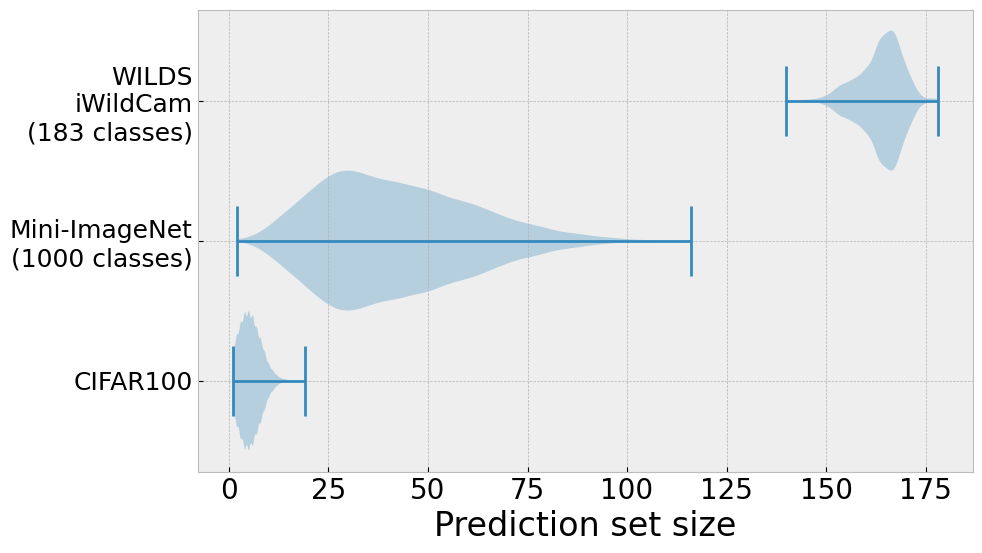

In [185]:
fontsize=24
plt.figure(figsize=(10, 6))
plt.violinplot(sizes, vert=False, widths=1.0)
plt.xlabel('Prediction set size', fontsize=fontsize)
plt.xticks(fontsize=fontsize-4)
plt.yticks(ticks=range(1, 4), labels=[f'CIFAR100', f'Mini-ImageNet\n(1000 classes)', f'WILDS\niWildCam\n({len(wild_classes)} classes)'], fontsize=fontsize-6)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

axs[1, 1].violinplot(data, pos, points=100, vert=False, widths=0.9,
                     showmeans=True, showextrema=True, showmedians=True,
                     bw_method='silverman')
axs[1, 1].set_title('Custom violinplot 7', fontsize=fs)